In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import torch
from torch import nn
from torch.utils import data
import torchvision as vis
import sys

# torch.manual_seed(117850791)
is_windows = sys.platform == "win32"
has_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if has_cuda else "cpu")
device

device(type='cuda', index=0)

In [16]:
!rm /home/ubuntu/data/unique-142p/.DS_Store

In [3]:
from PIL import Image
import os

class FlatImageData(vis.datasets.VisionDataset):
  def __init__(self, root, transform, validation_reserved_images=31136):
    self.root = root
    self.images = os.listdir(root)
    suffix_start = self.images[0].rfind(".") - len(self.images[0])
    self.images.sort(key=lambda x: int(x[6:suffix_start]))# sort by frame no.
    self.transform = transform
    self.training_mode = True
    self.reserved_images = validation_reserved_images
        
  def __len__(self):
    if self.training_mode:
      return len(self.images) - self.reserved_images
    else:
      return self.reserved_images
    
  def pil_loader(self, path: str) -> Image.Image:
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

  def __getitem__(self, index):
    if self.training_mode:
      index += self.reserved_images
    
    image_name = self.images[index]
    image_path = f"{self.root}/{image_name}"
    image = self.pil_loader(image_path)
    if self.transform is not None:
         image = self.transform(image)

    return image

  def collate_fn(batch):
      return torch.as_tensor(batch)
    
class ImageWindow(data.Dataset):
  def __init__(self, dataset, wide_window_size):
    self.dataset = dataset
    self.wide_window_size = wide_window_size
    self.window_offset = 0
  
  def shuffle(self):
    self.window_offset = torch.randint(0, self.wide_window_size, (1,)).item()
  
  def __len__(self):
    return (len(self.dataset) - self.window_offset) // self.wide_window_size
  
  def __getitem__(self, index):
    image_index_start = self.window_offset + index * self.wide_window_size
    images = [self.dataset[image_idx] for image_idx in
              range(image_index_start, image_index_start + self.wide_window_size, 1)]
    return torch.stack(images, dim=0)

In [17]:
input_size = 64
validation_dataset = FlatImageData(root="/home/ubuntu/data/unique-142p",
                             transform=vis.transforms.Compose([
                               vis.transforms.ToTensor(),
                               nn.AdaptiveAvgPool2d((input_size, input_size))
                             ]), validation_reserved_images=14196
                       )

validation_dataset.training_mode = False
validation_dataset

Dataset FlatImageData
    Number of datapoints: 14196
    Root location: /home/ubuntu/data/unique-142p

In [4]:
input_size = 64
validation_dataset = FlatImageData(root="/home/ubuntu/data/knnw-256p",
                             transform=vis.transforms.Compose([
                               vis.transforms.ToTensor(),
                               nn.AdaptiveAvgPool2d((input_size, input_size))
                             ])
                       )

validation_dataset.training_mode = False
validation_dataset

Dataset FlatImageData
    Number of datapoints: 31136
    Root location: /home/ubuntu/data/knnw-256p

In [6]:
validation_window = ImageWindow(validation_dataset, 1)

In [5]:
from torch.nn import functional as F
from typing import List, Callable, Union, Any, TypeVar, Tuple
Tensor = TypeVar('torch.tensor')



class BetaVAE(nn.Module):

    num_iter = 0 # Global static variable to keep track of iterations

    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 beta: int = 4,
                 gamma:float = 1000.,
                 max_capacity: int = 25,
                 capacity_max_iter: int = 1e5,
                 loss_type:str = 'B',
                 **kwargs) -> None:
        super(BetaVAE, self).__init__()

        self.latent_dim = latent_dim
        self.beta = beta
        self.gamma = gamma
        self.loss_type = loss_type
        self.C_max = torch.Tensor([max_capacity])
        self.C_stop_iter = capacity_max_iter

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim
            
        modules.append(nn.Flatten())

        self.encoder = nn.Sequential(*modules)
        
        self.fc_mu = nn.Linear(hidden_dims[-1]*(input_size // 32) ** 2, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*(input_size // 32) ** 2, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * (input_size // 32) ** 2)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1))

    def encode(self, inputs: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(inputs)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return (inputs, mu, log_var)

    def decode(self, z: Tensor) -> Tensor:
        result = self.decoder_input(z)
        result = result.view(-1, 512, (input_size // 32), (input_size // 32))
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Will a single z be enough ti compute the expectation
        for the loss??
        :param mu: (Tensor) Mean of the latent Gaussian
        :param logvar: (Tensor) Standard deviation of the latent Gaussian
        :return:
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, inputs: Tensor, **kwargs) -> Tensor:
        inputs, mu, log_var = self.encode(inputs)
        z = self.reparameterize(mu, log_var)
        
        self.current_inputs = inputs
        self.current_mu = mu
        self.current_log_var = log_var
        self.current_recon = self.decode(z)
        
        return self.current_recon

    def loss(self, *args, **kwargs) -> dict:
        self.num_iter += 1
        recons = self.current_recon
        input = self.current_inputs
        mu = self.current_mu
        log_var = self.current_log_var
        kld_weight = kwargs['kld_weight']  # Account for the minibatch samples from the dataset
        
        # since the image value is normalized between 0~1, BCE loss is better
        batch_size = recons.shape[0]
        recons_loss =F.binary_cross_entropy_with_logits(recons, input, reduction='sum') / batch_size
  
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        if self.loss_type == 'H': # https://openreview.net/forum?id=Sy2fzU9gl
            loss = recons_loss + self.beta * kld_weight * kld_loss
        elif self.loss_type == 'B': # https://arxiv.org/pdf/1804.03599.pdf
            self.C_max = self.C_max.to(input.device)
            C = torch.clamp(self.C_max/self.C_stop_iter * self.num_iter, 0, self.C_max.data[0])
            loss = recons_loss + self.gamma * kld_weight * (kld_loss - C).abs()
        else:
            raise ValueError('Undefined loss type.')

        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':kld_loss}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

In [15]:
# many to one 128x128
from torch.nn import functional as F
from typing import List, Callable, Union, Any, TypeVar, Tuple
Tensor = TypeVar('torch.tensor')

class BetaVAE(nn.Module):

    num_iter = 0 # Global static variable to keep track of iterations

    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 beta: int = 4,
                 gamma:float = 1000.,
                 max_capacity: int = 25,
                 Capacity_max_iter: int = 1e5,
                 loss_type:str = 'B',
                 **kwargs) -> None:
        super(BetaVAE, self).__init__()

        self.latent_dim = latent_dim
        self.beta = beta
        self.gamma = gamma
        self.loss_type = loss_type
        self.C_max = torch.Tensor([max_capacity])
        self.C_stop_iter = Capacity_max_iter

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim
            
        modules.append(nn.Flatten())

        self.encoder = nn.Sequential(*modules)
        
        self.fc_mu = nn.Linear(hidden_dims[-1]*16, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*16, latent_dim)

        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 16)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1))

    def encode(self, inputs: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x Window x C x H x W]
        :return: (Tensor) List of latent codes
        """
        
        batch_size, window_size, C, H, W = inputs.shape
        
        result = self.encoder(inputs.view(-1, C, H, W))
        
        # use average
        conmbined_features = result.view(batch_size, window_size, -1).mean(dim=1)
        
#         # sliding window
#         for batch_i in range(batch_size):
#           for window_i in range(wide_window_size - self.window_size + 1):
#             concated_features.append(result[batch_i, window_i:window_i+self.window_size, :].flatten())
            
#         concated_features = torch.stack(concated_features)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(conmbined_features)
        log_var = self.fc_var(conmbined_features)

        return (inputs, mu, log_var)

    def decode(self, z: Tensor) -> Tensor:
        result = self.decoder_input(z)
        result = result.view(-1, 512, 4, 4)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Will a single z be enough to compute the expectation
        for the loss??
        :param mu: (Tensor) Mean of the latent Gaussian
        :param logvar: (Tensor) Standard deviation of the latent Gaussian
        :return:
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, inputs: Tensor, **kwargs) -> Tensor:
        inputs, mu, log_var = self.encode(inputs)
        z = self.reparameterize(mu, log_var)
        
        self.current_inputs = inputs
        self.current_mu = mu
        self.current_log_var = log_var
        self.current_recon = self.decode(z)
        
        return self.current_recon

    def loss(self, *args, **kwargs) -> dict:
        self.num_iter += 1
        recons = self.current_recon
        input = self.current_inputs
        mu = self.current_mu
        log_var = self.current_log_var
        kld_weight = kwargs['kld_weight']  # Account for the minibatch samples from the dataset
        
        batch_size = recons.shape[0]
        window_size = input.shape[1]
        recons_loss =F.binary_cross_entropy_with_logits(recons.unsqueeze(dim=1).expand_as(input),
                                                        input, reduction='sum') / batch_size / window_size
  
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        if self.loss_type == 'H': # https://openreview.net/forum?id=Sy2fzU9gl
            loss = recons_loss + self.beta * kld_weight * kld_loss
        elif self.loss_type == 'B': # https://arxiv.org/pdf/1804.03599.pdf
            self.C_max = self.C_max.to(input.device)
            C = torch.clamp(self.C_max/self.C_stop_iter * self.num_iter, 0, self.C_max.data[0])
            loss = recons_loss + self.gamma * kld_weight * (kld_loss - C).abs()
        else:
            raise ValueError('Undefined loss type.')

        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':kld_loss}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [6]:
import os
model_store = "model_checkpoints"

class StoredModel:
  def __init__(self, model, optimizer, scheduler, criterion):
    self.model = model
    self.optimizer = optimizer
    self.scheduler = scheduler
    self.criterion = criterion

In [7]:
def load_model(model_id, specific_epoch = None):
  global optimizer, scheduler
  epoch_start = -1
  for checkpoint in os.listdir(f"{model_store}/{model_id}"):
    if not checkpoint.startswith("epoch"):
      continue
    epoch = int(checkpoint.split("_")[1])
    if specific_epoch is None:
      # find the latest
      if epoch > epoch_start:
        epoch_start = epoch
        last_checkpoint = checkpoint
    else:
      if epoch == specific_epoch:
        epoch_start = epoch
        last_checkpoint = checkpoint
        break

  if epoch_start == -1:
    print(f"No checkpoints available for {model_id}!")
    return -1, None
  else:
    epoch_start += 1
    print(f"resuming from last checkpoint {last_checkpoint}")
    data = torch.load(f"{model_store}/{model_id}/{last_checkpoint}")
    
    model = data.model
    optimizer = data.optimizer
    scheduler = data.scheduler
    criterion = data.criterion
    
    model.to(device)
    return epoch_start, model, criterion

In [35]:
model_id = "baseline_BCE_B_loss_64x64_128_latent"
epoch_start, model, criterion = load_model(model_id)
model.eval()

resuming from last checkpoint epoch_39_tr-loss_5792.547781


BetaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Seque

## Run the model through validation dataset

In [36]:
from tqdm import tqdm

validataion_dataloader_args = dict(batch_size=128, shuffle=False,
                             num_workers=0 if is_windows else 4) if has_cuda else dict(batch_size=64)

# validataion_dataloader = data.DataLoader(validation_window, **validataion_dataloader_args)
validataion_dataloader = data.DataLoader(validation_dataset, **validataion_dataloader_args)

# set model in training mode
model.eval()

latent_mu = list()
latent_log_var = list()

for i, x in enumerate(tqdm(validataion_dataloader, desc="Validate")):
  x = x.to(device)

  _, mus, log_vars = model.encode(x)
  latent_mu.append(mus.detach().cpu())
  latent_log_var.append(log_vars.detach().cpu())

Validate: 100%|██████████| 111/111 [00:08<00:00, 13.42it/s]


In [37]:
latent_mu = torch.vstack(latent_mu)
latent_log_var = torch.vstack(latent_log_var)

In [124]:
torch.save((latent_mu, latent_log_var), f"temp_store/{model_id}_latent_vectors_142p")

In [43]:
latent_mu, latent_log_var = torch.load(f"temp_store/baseline_BCE_B_loss_64x64_10_latent_latent_vectors_142p")

In [208]:
latent_mu = latent_mu[:, top_10_divergent.indices]
latent_log_var = latent_log_var[:, top_10_divergent.indices]

In [38]:
from tqdm import tqdm

L2_divergence_latent = list()

for i in tqdm(range(len(latent_mu) - 1), desc="L2"):
  image_1 = torch.cat((latent_mu[i], torch.exp(latent_log_var[i]).sqrt()))
  image_2 = torch.cat((latent_mu[i + 1], torch.exp(latent_log_var[i + 1]).sqrt()))
  
  # Wasserstein
  diff = (image_1 - image_2).flatten()
  L2_divergence_latent.append(torch.linalg.norm(diff, 2).item())
  # KLD
#   L2_divergence_latent.append(((latent_log_var[i + 1] - latent_log_var[i]) / 2 +
#                               (latent_log_var[i].exp() + (latent_mu[i] - latent_mu[i + 1]) ** 2) /
#                                 (2 * latent_log_var[i + 1].exp())
#                                - 0.5).sum()
#                              )

L2: 100%|██████████| 14195/14195 [00:00<00:00, 18784.43it/s]


In [21]:
# 142p
from math import floor
scene_changes = []
with open("data/scene-change.csv") as f:
    lines = f.readlines()
    for line in lines[1:]:
        scenes = line[:-1].split(',')
        scene_changes.append([scenes[0], scenes[1]])

In [22]:
scene_change_ids = list()

for idx, image_id in enumerate(validation_dataset.images):
  if len(scene_changes) > 0 and image_id == scene_changes[0][0]:
    del scene_changes[0]
    scene_change_ids.append(idx)

In [23]:
scene_change_ids = set(scene_change_ids)

In [12]:
# 720p
from math import floor
scene_changes = []
with open("data/scene-change.csv") as f:
    lines = f.readlines()
    for line in lines[1:]:
        scenes = line.split(',')
        scene_changes.append([floor(int(scenes[0][6:12])/25*30+28), floor(int(scenes[1][6:12])/25*30+32)])

In [13]:
for i in range(len(scene_changes) - 1):
  scene1 = scene_changes[i]
  scene2 = scene_changes[i+1]
  
  if scene1[1] >= scene2[0]:
    print(scene1[1], scene2[0])
    scene2[0] = scene1[1] + 1

1566 1562
1972 1968
2738 2734
6023 6019
6972 6968
25650 25646


In [14]:
import numpy as np
L2_divergence_latent = np.array(L2_divergence_latent)

max_l2_per_scene_change = list()

for start_id, end_id in scene_changes:
  start_id -= 1
  max_l2_per_scene_change.append(max(L2_divergence_latent[start_id: end_id]))
  
max_l2_per_scene_change = np.array(sorted(max_l2_per_scene_change, reverse=True))

In [24]:
correct = list()
total = list()

for i, divergence in enumerate(max_l2_per_scene_change):
  correct.append(i + 1)
  total.append((L2_divergence_latent[700:] >= divergence).sum())

In [32]:
from sklearn.manifold import TSNE

tsne_embedded = TSNE(n_components=2, n_jobs=-1).fit_transform(
  torch.cat((latent_mu, torch.exp(latent_log_var).sqrt()), dim=1))

In [33]:
torch.save(tsne_embedded, f"temp_store/{model_id}_tsne_embed")

In [34]:
labels = list()

prev_end = 0
for i, (start_id, end_id) in enumerate(scene_changes):

  labels.extend([i] * (start_id - prev_end))
  labels.extend(np.arange(i, i+1, 1 / (end_id - start_id)))
  
  prev_end = end_id
  if end_id != len(labels):
    print(i, start_id, end_id, len(labels))
    break

len(labels)

30826

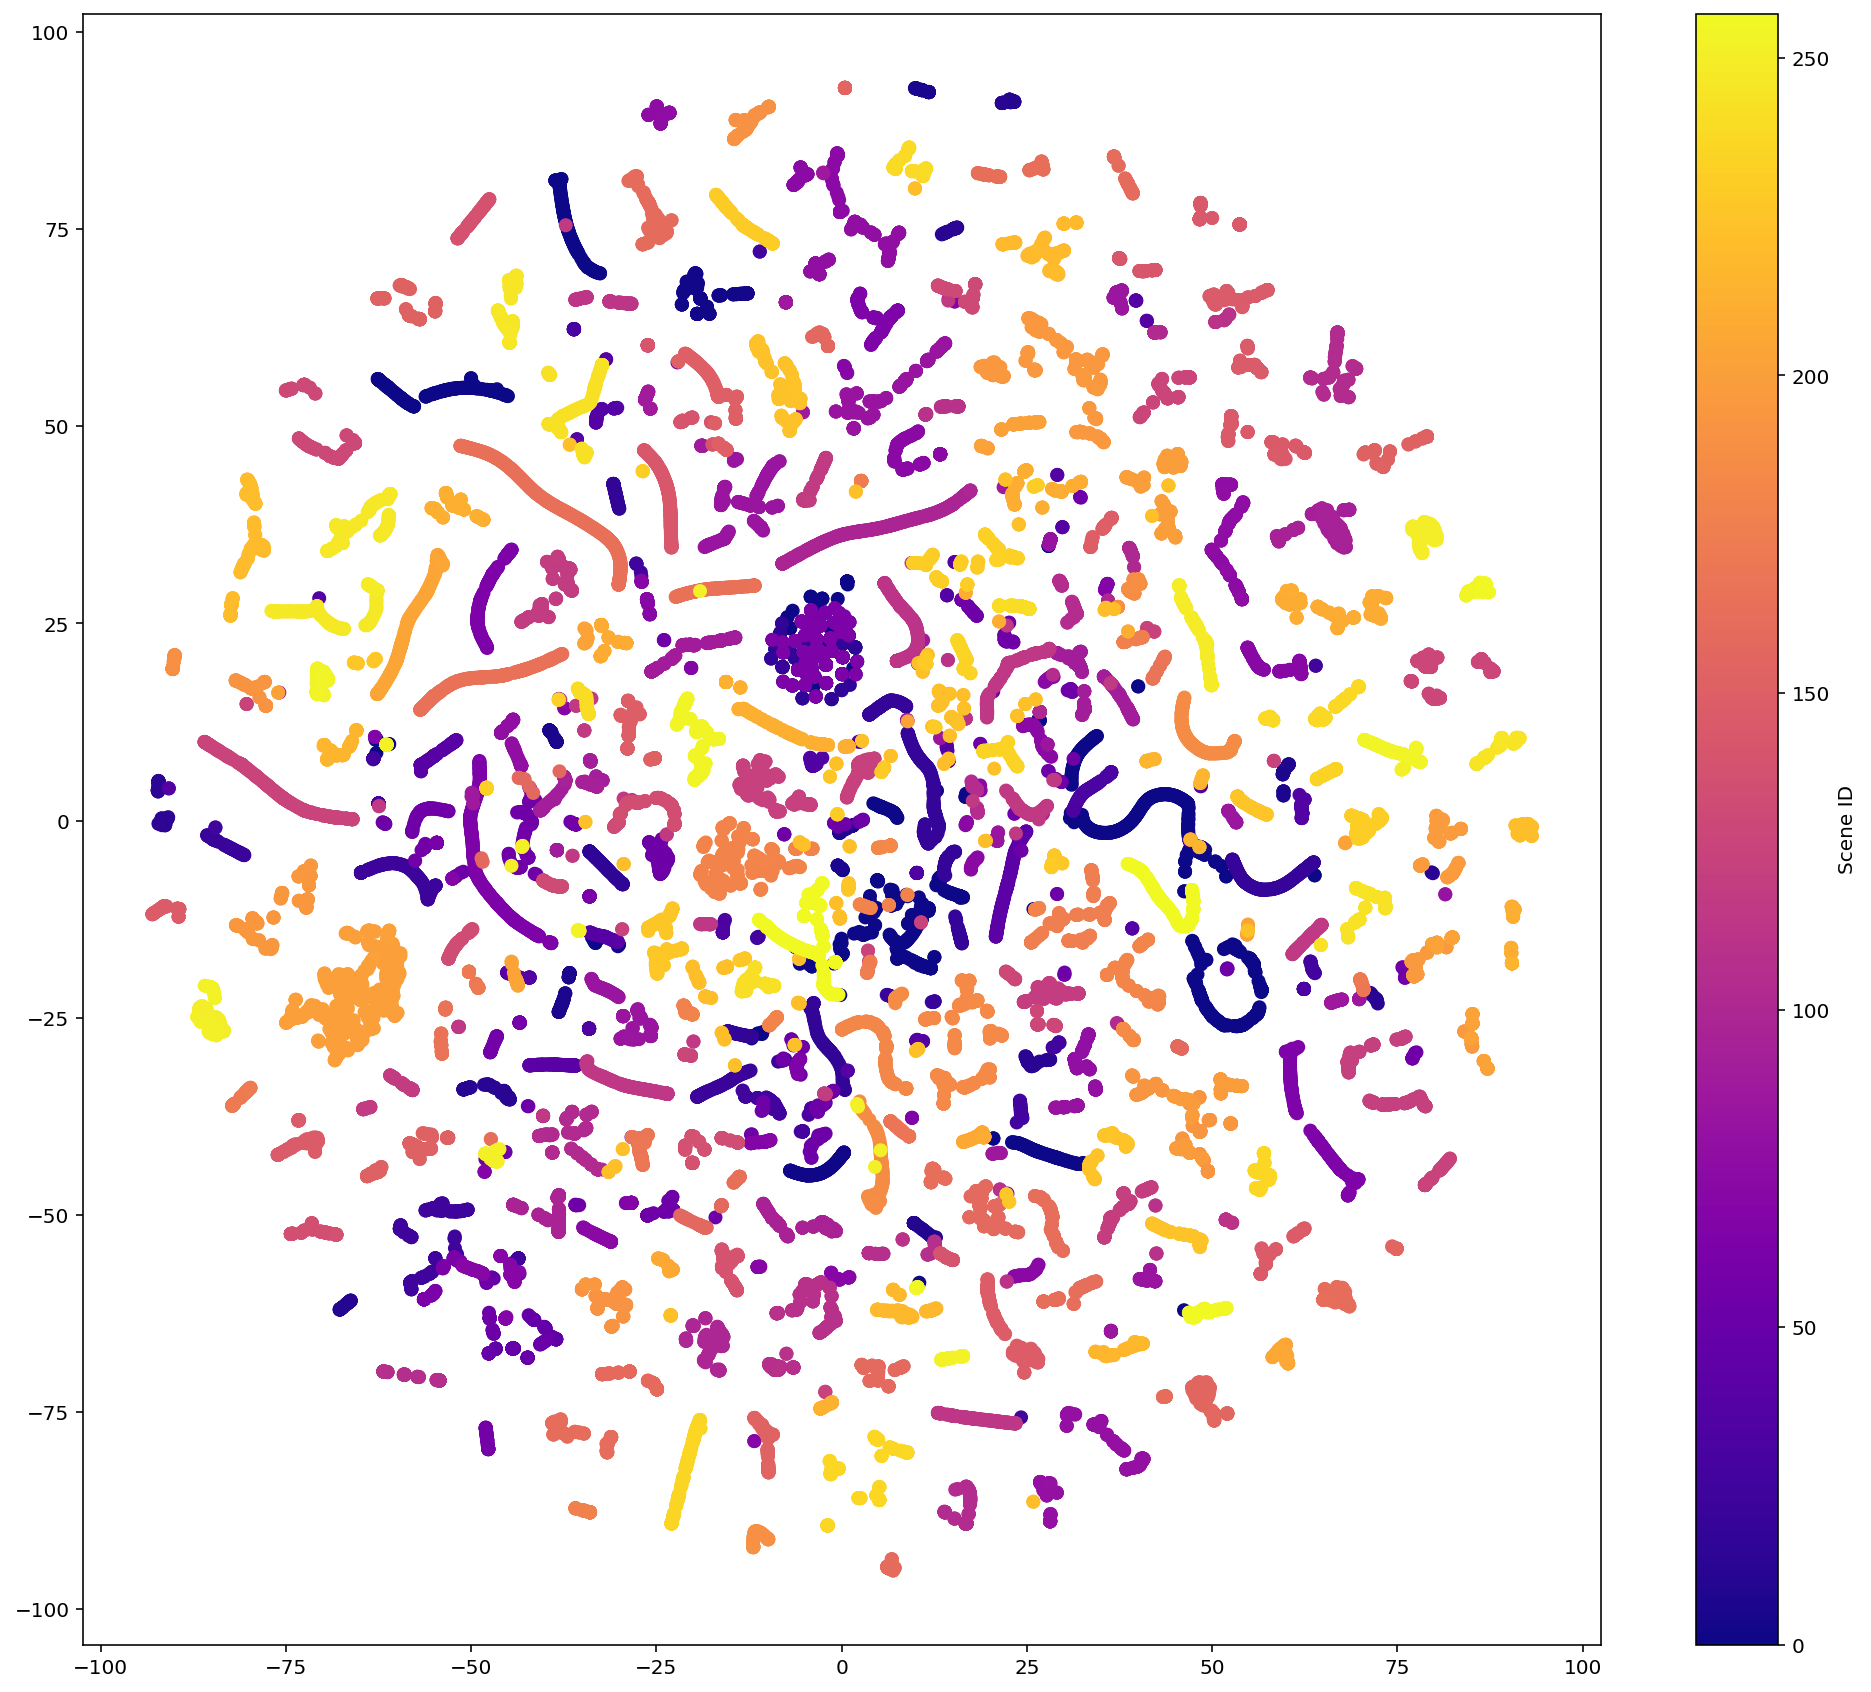

In [37]:
from matplotlib import pyplot as plt

fig = plt.figure(1, (17., 15.))
plt.scatter(tsne_embedded[:, 0], tsne_embedded[:, 1], alpha=1.0,
            c=labels + [i + 1] * (tsne_embedded.shape[0] - len(labels)), cmap="plasma")
cb = plt.colorbar()
cb.set_label('Scene ID')

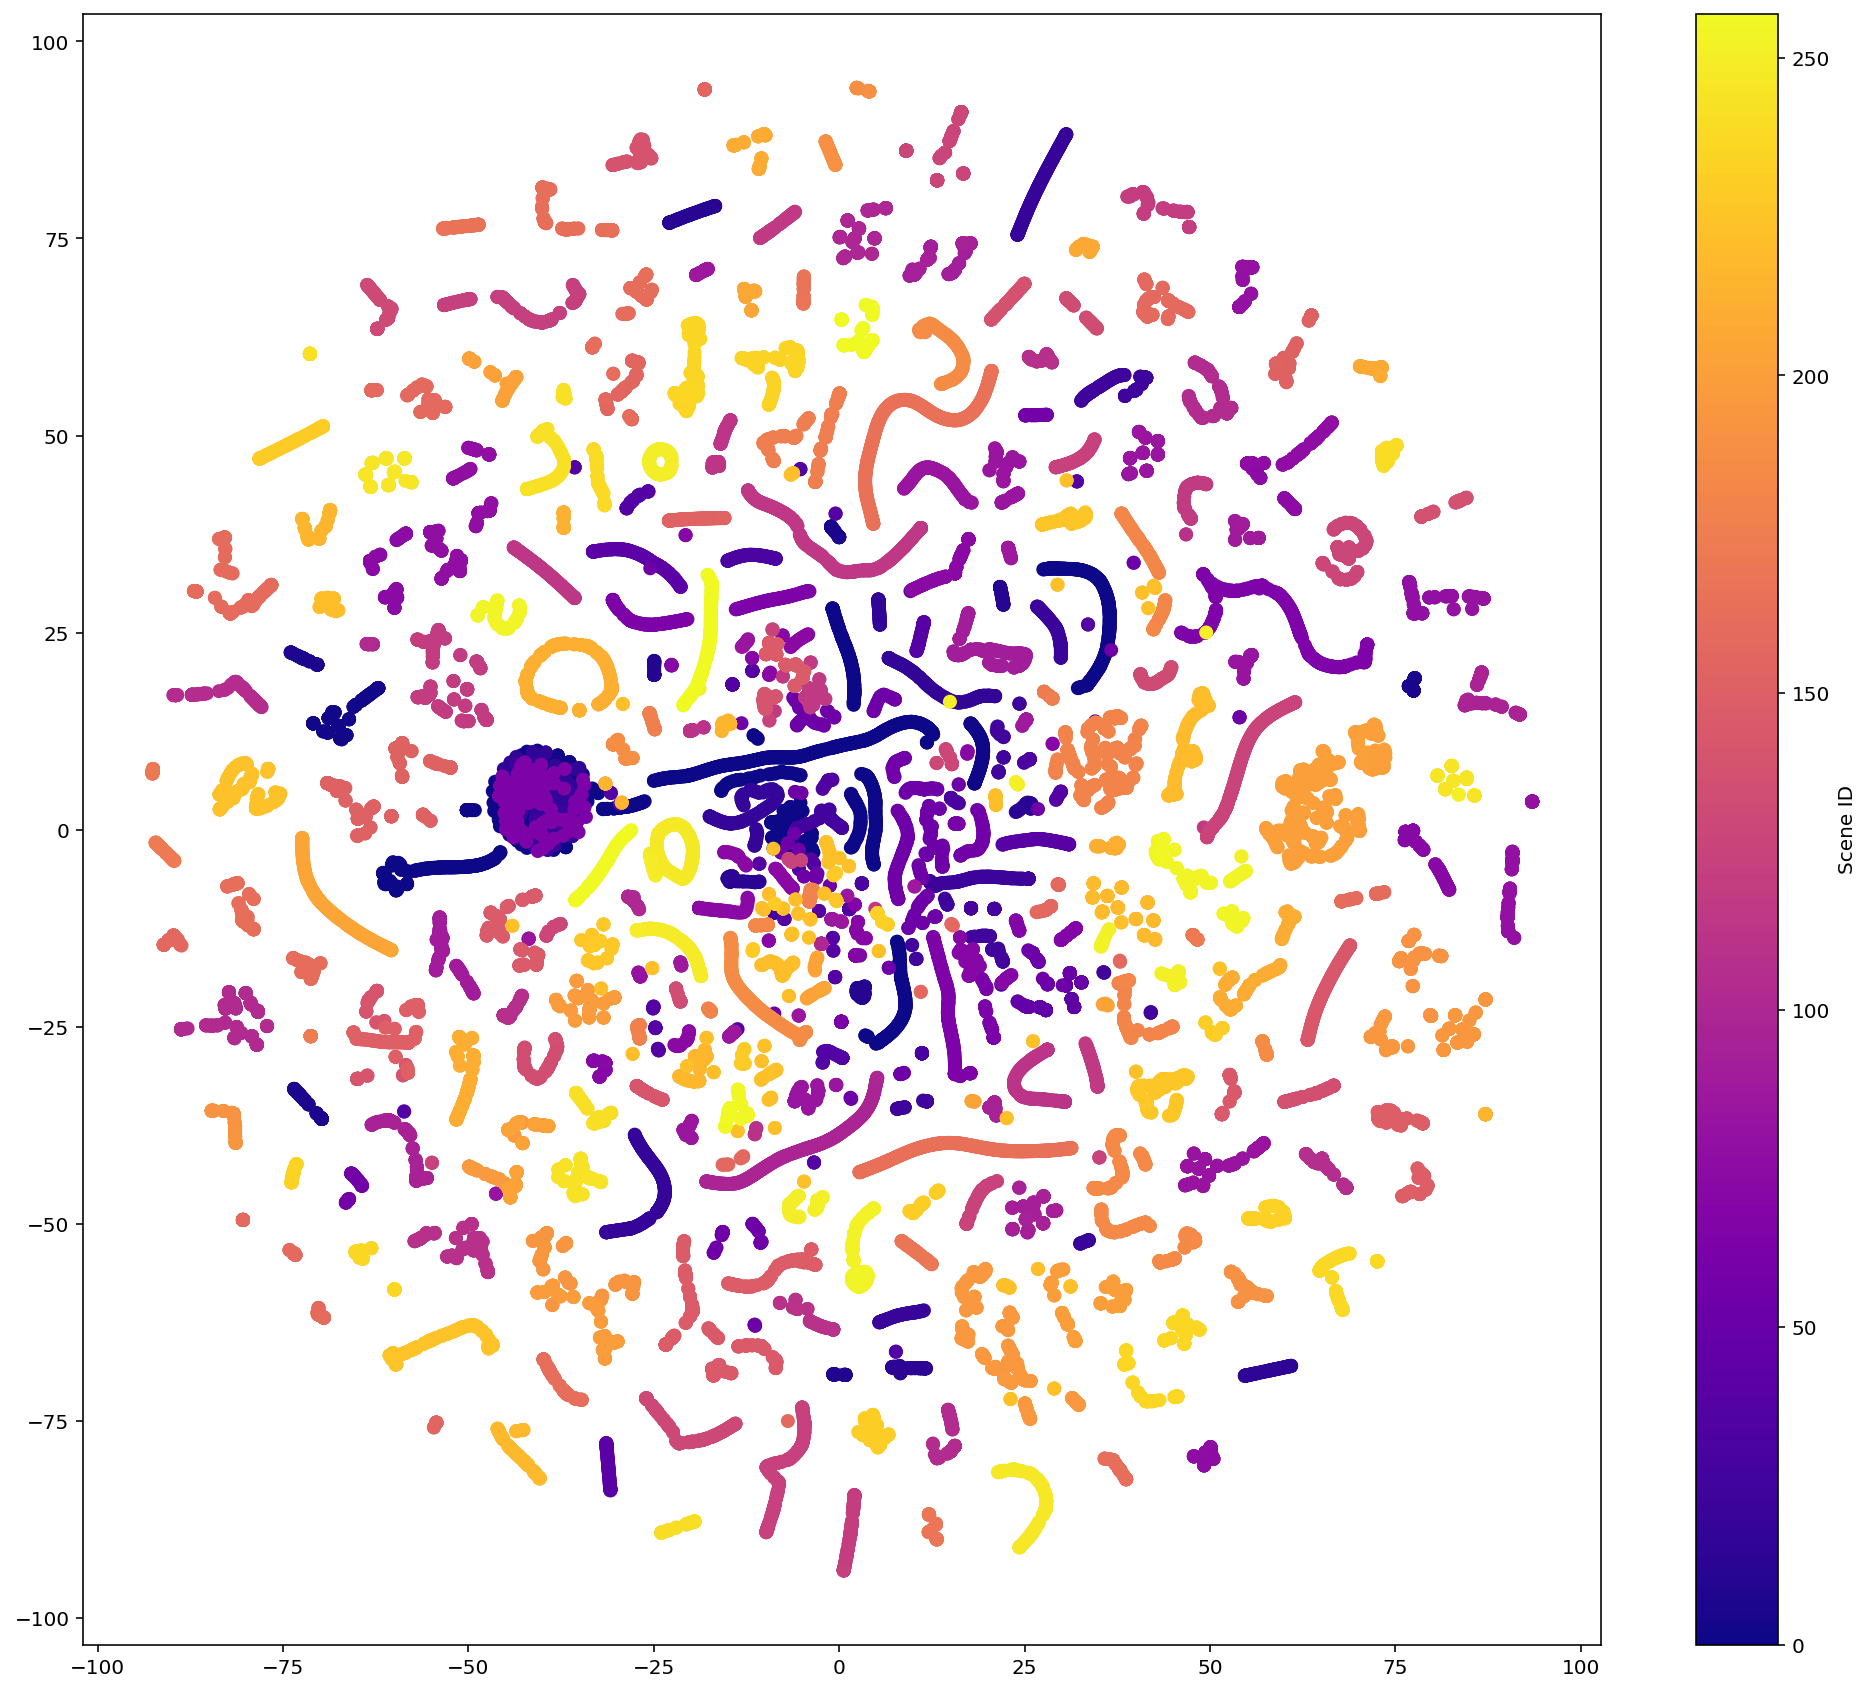

In [199]:
from matplotlib import pyplot as plt

fig = plt.figure(1, (17., 15.))
plt.scatter(tsne_embedded[:, 0], tsne_embedded[:, 1], alpha=1.0,
            c=labels + [i + 1] * (tsne_embedded.shape[0] - len(labels)), cmap="plasma")
cb = plt.colorbar()
cb.set_label('Scene ID')

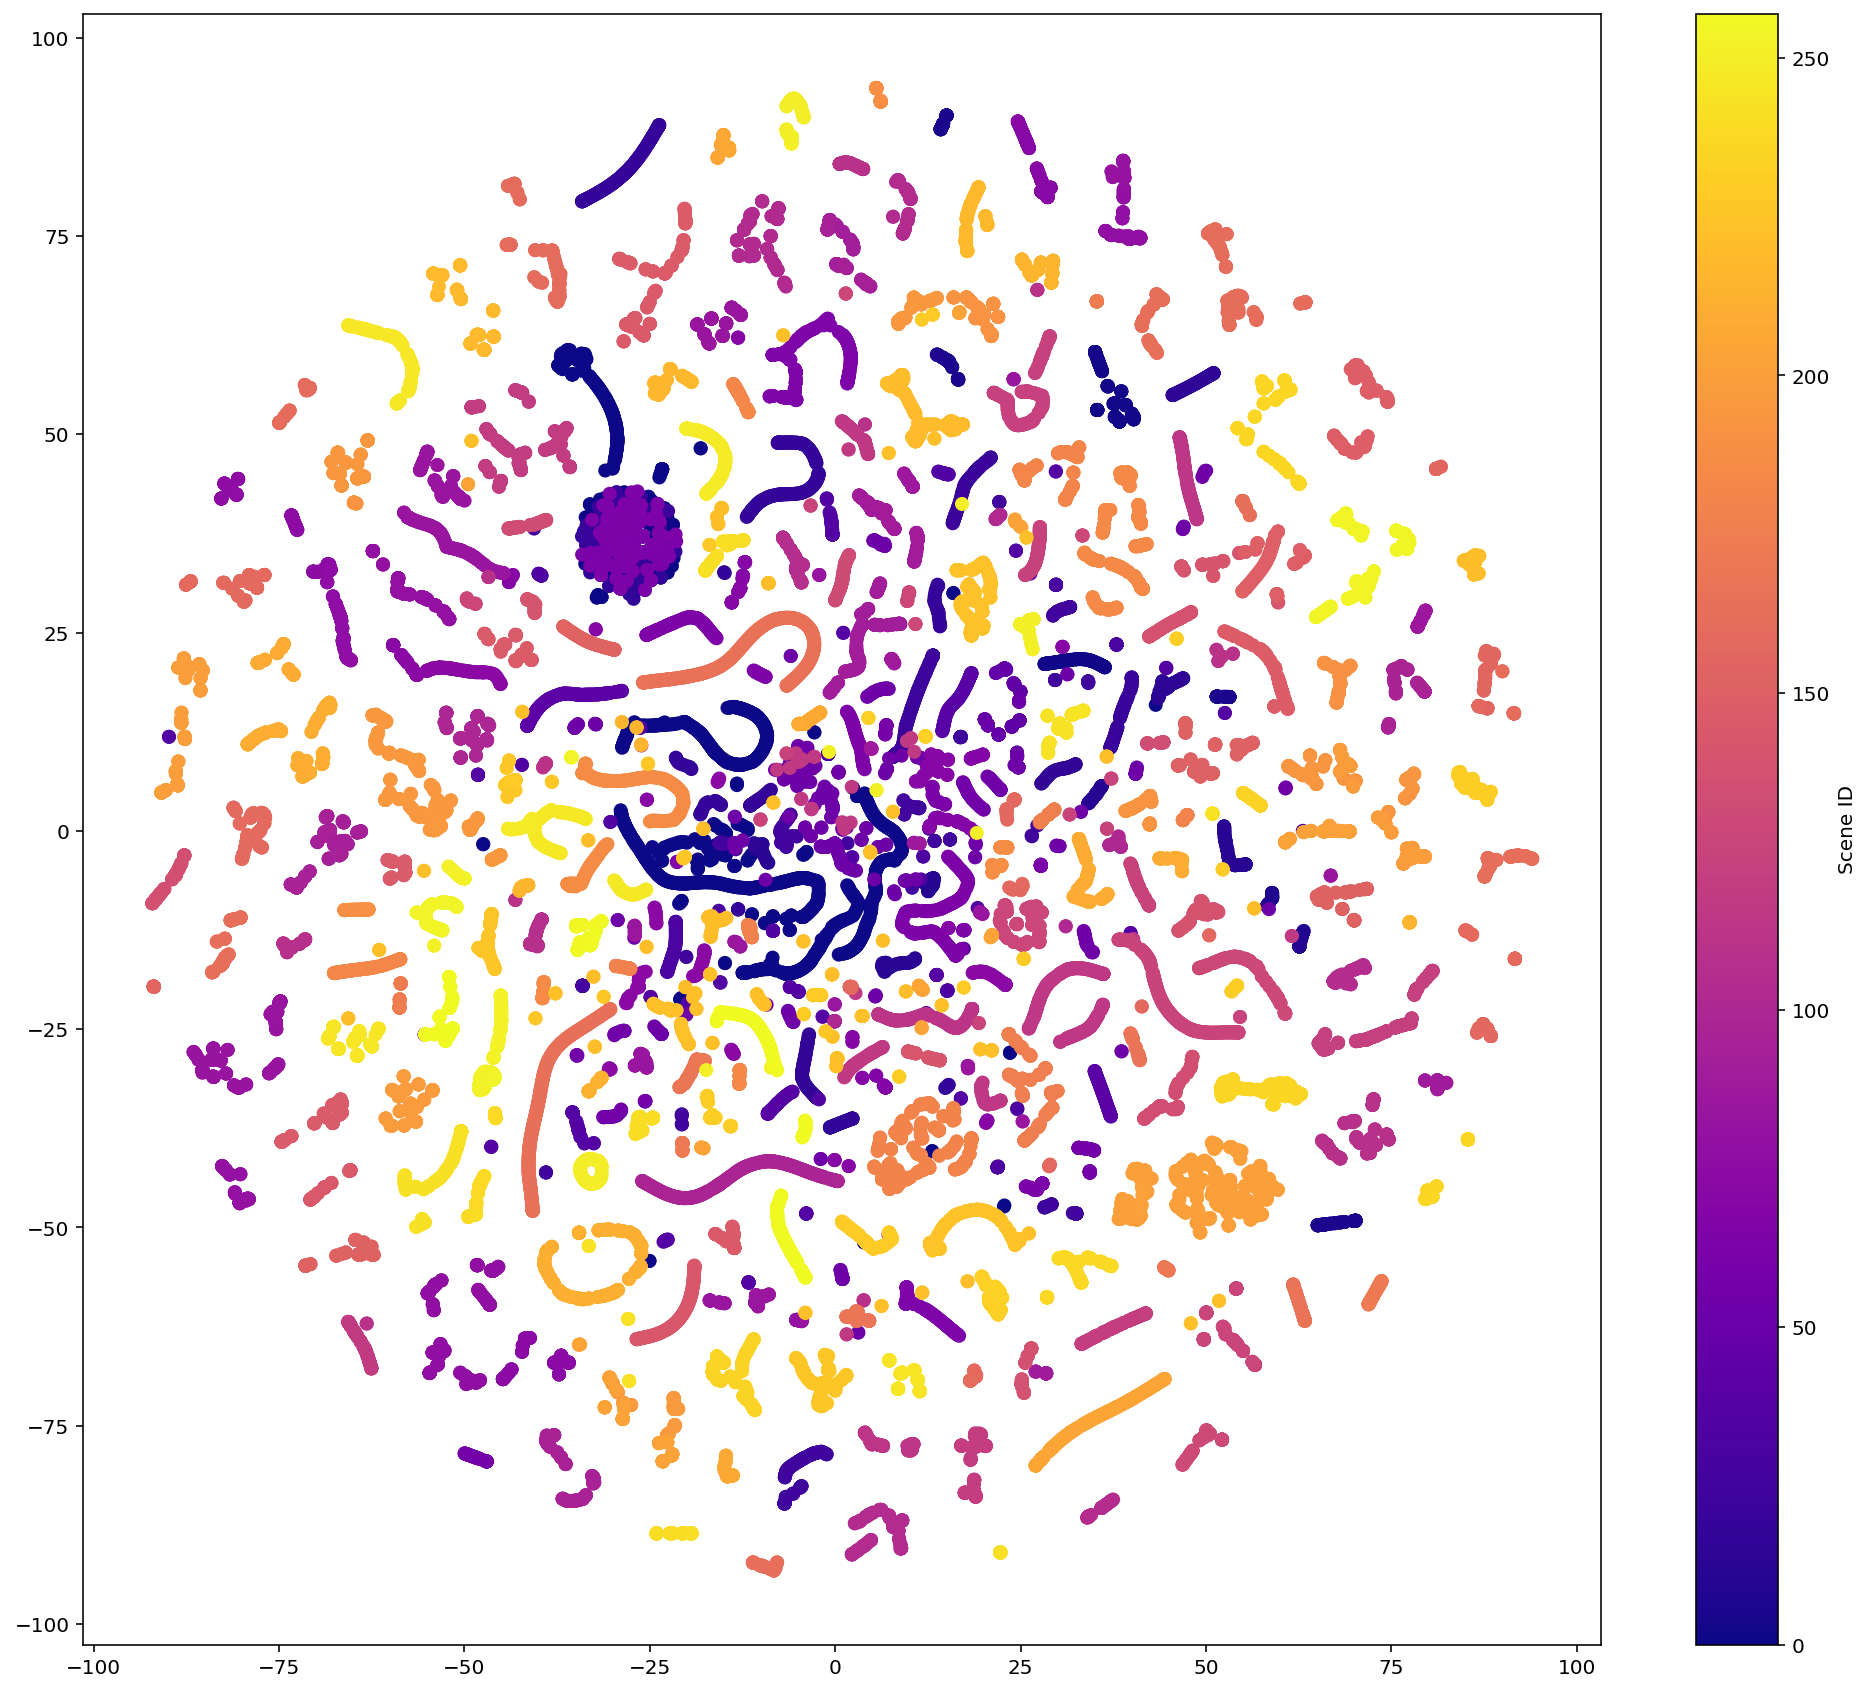

In [215]:
from matplotlib import pyplot as plt

fig = plt.figure(1, (17., 15.))
plt.scatter(tsne_embedded[:, 0], tsne_embedded[:, 1], alpha=1.0,
            c=labels + [i + 1] * (tsne_embedded.shape[0] - len(labels)), cmap="plasma")
cb = plt.colorbar()
cb.set_label('Scene ID')

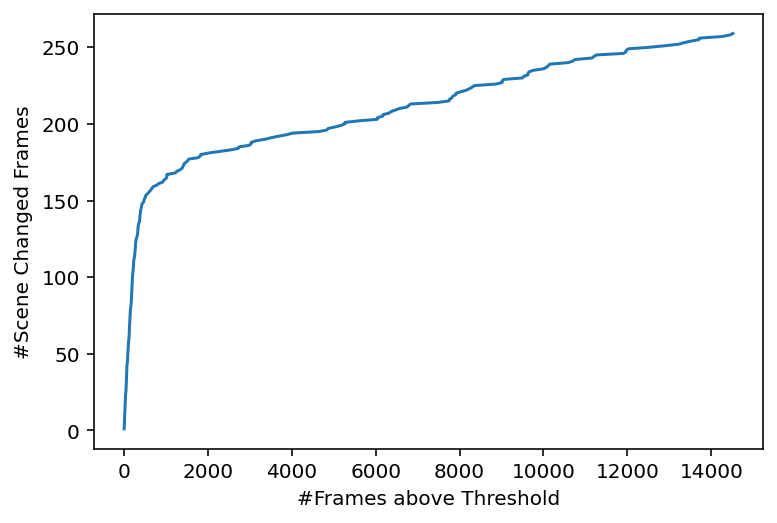

In [210]:
# top 20 many to one
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_ylabel('#Scene Changed Frames')
ax1.set_xlabel('#Frames above Threshold')
plt.plot(total, correct)

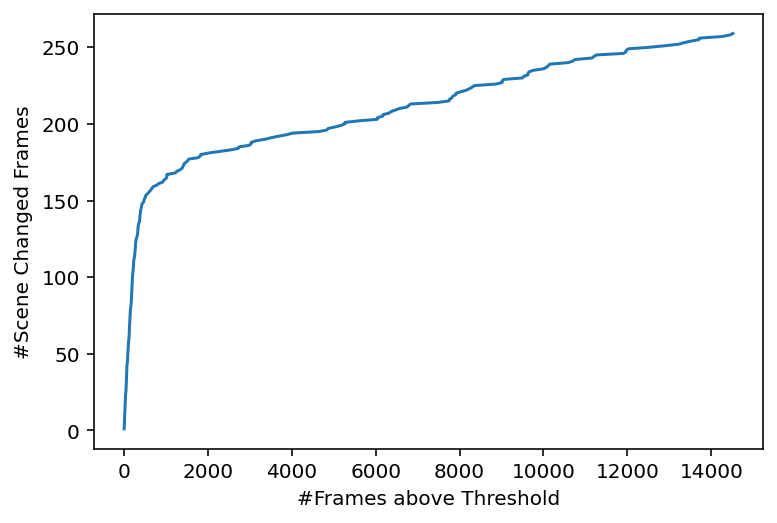

In [25]:
# all latent many to one
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_ylabel('#Scene Changed Frames')
ax1.set_xlabel('#Frames above Threshold')
plt.plot(total, correct)

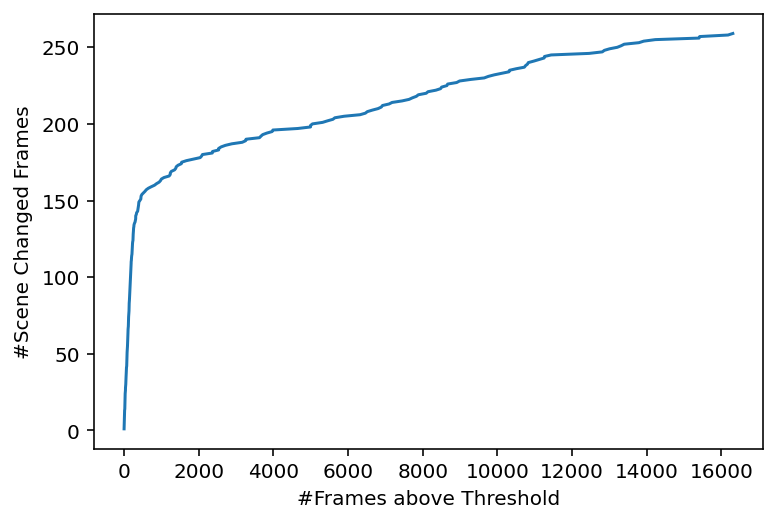

In [18]:
# all latent
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_ylabel('#Scene Changed Frames')
ax1.set_xlabel('#Frames above Threshold')
plt.plot(total, correct)

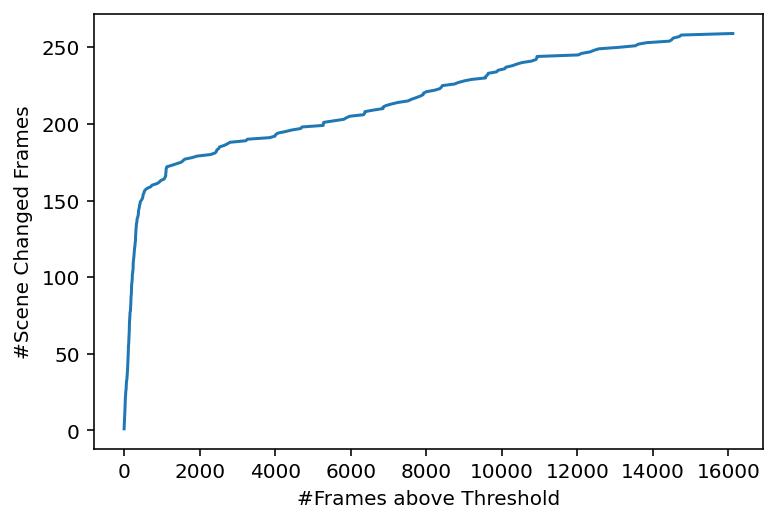

In [69]:
# top 10 selected by neighboring frames
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_ylabel('#Scene Changed Frames')
ax1.set_xlabel('#Frames above Threshold')
plt.plot(total, correct)

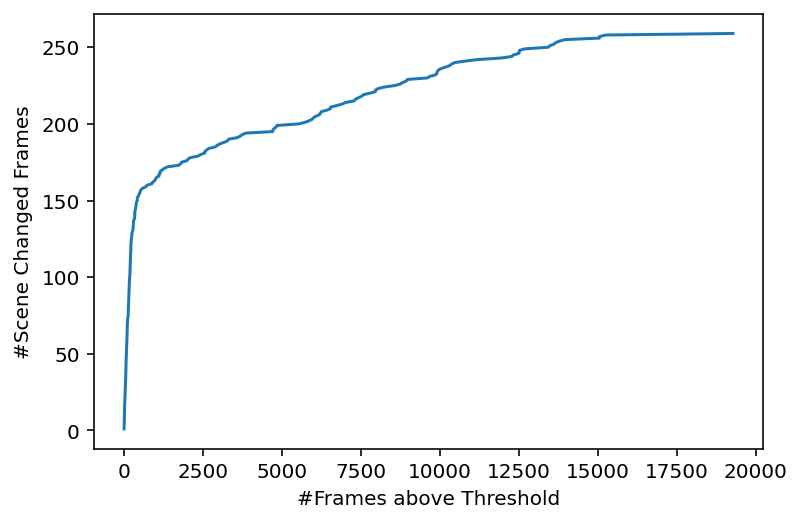

In [94]:
# top 10 selected by scene change boundary frames
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_ylabel('#Scene Changed Frames')
ax1.set_xlabel('#Frames above Threshold')
plt.plot(total, correct)

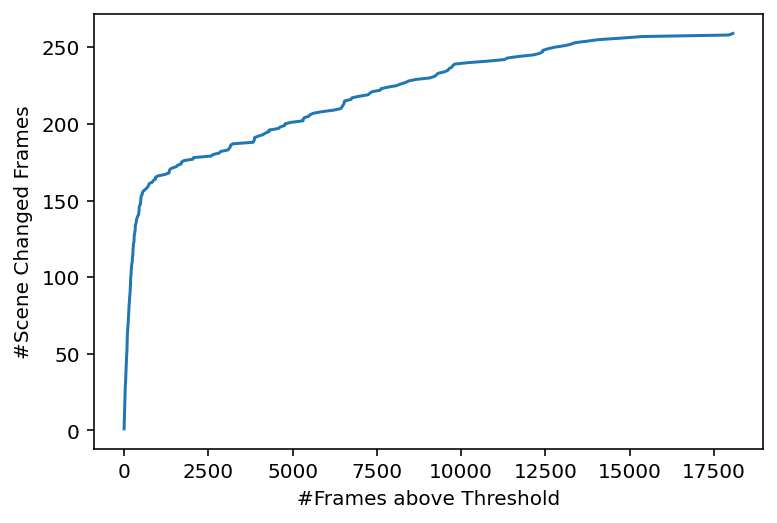

In [102]:
# top 5 selected by scene change boundary frames
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_ylabel('#Scene Changed Frames')
ax1.set_xlabel('#Frames above Threshold')
plt.plot(total, correct)

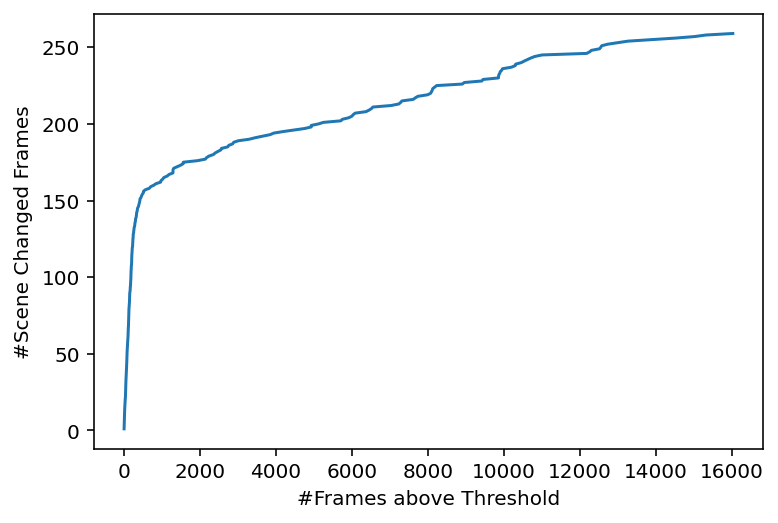

In [125]:
# top 20 selected by scene change boundary frames
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_ylabel('#Scene Changed Frames')
ax1.set_xlabel('#Frames above Threshold')
plt.plot(total, correct)

In [20]:
L2_divergence_latent[false_positive_list[5]]

3.836491584777832

In [202]:
validation_scene_changes = scene_changes[:100]
test_scene_changes = scene_changes[100:]

In [15]:
# collect the changed scene id
scene_change_ids = list()

for start_id, end_id in scene_changes:
  start_id -= 1
  scene_change_ids.append(np.argmax(L2_divergence_latent[start_id: end_id]) + start_id)
  
scene_change_ids = set(scene_change_ids)

In [39]:
scene_change_num = len(max_l2_per_scene_change)
predicted_scene_change = (-np.array(L2_divergence_latent)).argsort()[:257]
true_positive = 0
false_positive = 0

false_positive_list = list()

for pred in predicted_scene_change:
    if pred in scene_change_ids:
        true_positive += 1
    else:
        false_positive_list.append(pred)
        false_positive += 1
false_negative = scene_change_num - true_positive
true_negative = 31135 - scene_change_num - false_positive
precision = true_positive / (true_positive + false_positive)
# recall = true_positive / (true_positive + false_negative)
# f1 = precision * recall * 2 / (precision + recall)

print(precision)

0.7782101167315175


In [35]:
model.eval()
check_id = 4625
with torch.no_grad():
  _, latent_mu_1, latent_log_var_1 = model.encode(validation_dataset[check_id].unsqueeze(0).to(device))
  _, latent_mu_2, latent_log_var_2 = model.encode(validation_dataset[check_id + 1].unsqueeze(0).to(device))

In [13]:
false_positive_list[5]

4625

In [41]:
((latent_mu_1 - latent_mu_2) ** 2 +
 (latent_log_var_1.exp().sqrt() - latent_log_var_2.exp().sqrt()) ** 2).sum().sqrt()

tensor(3.8365, device='cuda:0')

In [37]:
latent_log_var_1, latent_log_var_2

(tensor([[ 0.0198, -8.9164, -6.0155, -5.9350, -0.4485, -1.3526, -0.1410, -0.1658,
          -5.5599, -0.0815]], device='cuda:0'),
 tensor([[-0.0452, -7.7773, -4.3825, -5.8503, -0.2990, -0.7645, -0.1068, -0.0766,
          -4.0428, -0.0698]], device='cuda:0'))

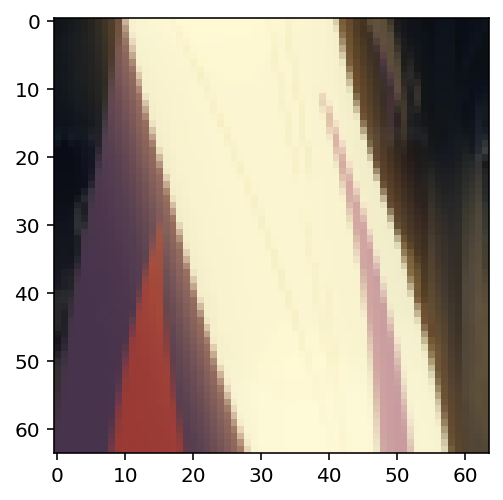

In [17]:
import matplotlib.pyplot as plt
plt.imshow(validation_dataset[4625].permute(1,2,0))

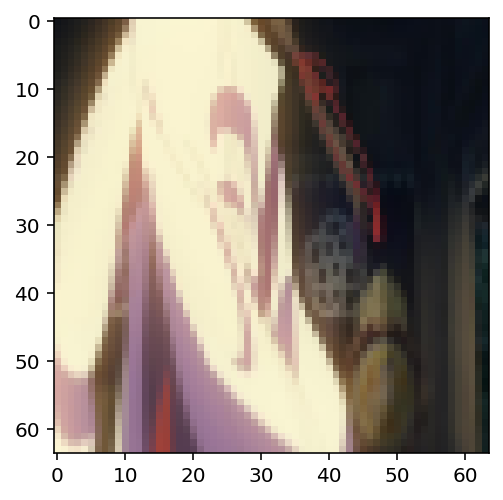

In [19]:
import matplotlib.pyplot as plt
plt.imshow(validation_dataset[4626].permute(1,2,0))

In [45]:
false_positive_list_720p = false_positive_list

In [53]:
false_positive_list[1]

2805

In [51]:
len(false_positive_list)

46

In [16]:
false_positive_list[5]

4625

In [38]:
validation_dataset.images[2810]

'frame_003834.png'

In [ ]:
latent

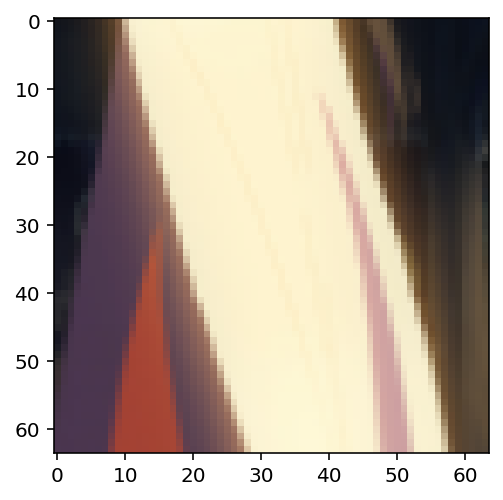

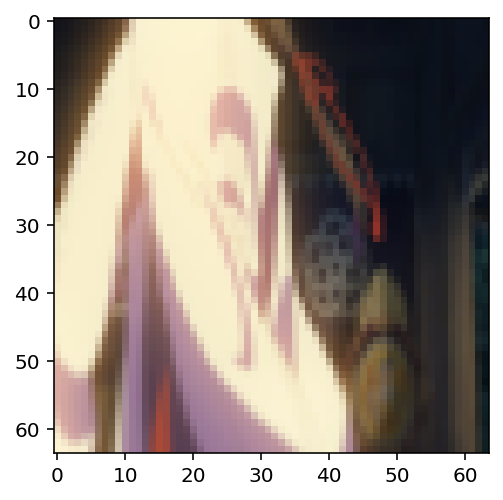

In [42]:
import matplotlib.pyplot as plt

i = 2805
plt.figure()
plt.imshow(validation_dataset[i].permute(1,2,0))
plt.figure()
plt.imshow(validation_dataset[i + 1].permute(1,2,0))

In [ ]:
import matplotlib.pyplot as plt

for i in false_positive_list:
  plt.figure()
  plt.imshow(validation_dataset[i].permute(1,2,0))
  plt.figure()
  plt.imshow(validation_dataset[i + 1].permute(1,2,0))

In [110]:
w_dist_latent = torch.zeros(latent_mu.shape[1])

for frame_id_after in scene_change_ids:
  frame_id_before = frame_id_after - 1
  w_dist_latent += (latent_mu[frame_id_before] - latent_mu[frame_id_after]) ** 2 +\
      (torch.exp(latent_log_var[frame_id_before]).sqrt()
       - torch.exp(latent_log_var[frame_id_after]).sqrt()) ** 2

In [111]:
# result looks better when the frames are consecutive
top_10_divergent = w_dist_latent.topk(10)
top_10_divergent

torch.return_types.topk(
values=tensor([14.2700,  6.1761,  5.0874,  3.3913,  2.9716,  2.5970,  2.3758,  1.6480,
         1.3664,  1.3314]),
indices=tensor([108,  51,  83,  33,  38,  19,  57,  14,  58,  21]))

In [203]:
w_dist_latent = torch.zeros(latent_mu.shape[1])

for frame_id_before, frame_id_after in validation_scene_changes:
  w_dist_latent += (latent_mu[frame_id_before] - latent_mu[frame_id_after]) ** 2 +\
      (torch.exp(latent_log_var[frame_id_before]).sqrt()
       - torch.exp(latent_log_var[frame_id_after]).sqrt()) ** 2

In [207]:
# this seem weird
top_10_divergent = w_dist_latent.topk(20)
top_10_divergent

torch.return_types.topk(
values=tensor([588.5983, 514.2936, 487.3835, 467.3595, 426.9446, 419.3708, 418.8734,
        418.4050, 408.3287, 406.9883, 400.5562, 400.1682, 380.4108, 368.2832,
        354.2445, 345.9527, 341.7168, 341.0907, 334.2758, 333.5150]),
indices=tensor([ 73,   7,  40,  68,  91,  86,  24, 105,  96,  76,  64,  82,  45, 110,
        108, 126,  57,  46,  13,  56]))